<a href="https://colab.research.google.com/github/ehsan-abdi/customer-segmentation-unsupervised-ml/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# E-Commerce Customer Segmentation for Growth Strategy

### Optimising Marketing ROI through Unsupervised Machine Learning

## Executive Summary
Successfully segmented a global e-commerce customer base of **68,000+ unique users** (950k transactions) into five actionable cohorts. By identifying distinct patterns in customer value and engagement, this project provides a framework for the Marketing Team to transition from "one-size-fits-all" messaging to **targeted retention and high-value acquisition strategies**.

## Business Problem
The company lacks a granular understanding of its diverse international customer base. Without segmentation, marketing spend is inefficiently distributed across low-value, inactive users and high-value brand advocates. The goal is to identify these hidden segments to **increase Customer Lifetime Value (CLV)** and **reduce churn**.

## Technical Approach
* **Scale:** Processed **~1M transaction records** across 47 countries.
* **Feature Engineering:** Engineered behavioural metrics including Recency, Frequency, and Monetary (RFM) equivalents from raw transactional logs.
* **Modelling:** Implemented **K-Means Clustering** optimised via Elbow Method, Silhouette Analysis and Hierarchical Dendrograms.
* **Validation:** Utilised **PCA** and **t-SNE** to visualise high-dimensional clusters and ensure segment interpretability.

# 1\. Library Imports and Global Configuration

In [1]:
# Core
import numpy as np
import pandas as pd

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit-learn
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Hierarchical clustering
import scipy.cluster.hierarchy as sch

In [2]:
# Data source
DATA_URL = (
    "https://github.com/ehsan-abdi/customer-segmentation-unsupervised-ml/"
    "raw/refs/heads/main/data/raw/raw-customer-data.zip"
)

# Reference date for time-based feature engineering (dataset end date)
REFERENCE_DATE = pd.Timestamp("2016-12-30")

# Reproducibility
SEED = 42

# 2\. Data Engineering & Preprocessing

## 2.1. Ingestion & Initial Audit

**Objective:** Assess the integrity and structure of the ~950k-record transactional dataset prior to feature engineering.

**Key Findings:**

- **Schema inconsistencies:** Financial and temporal fields stored as string types.

- **Accounting Notation:** Negative values in currency columns use parentheses (e.g., ($5.00)), requiring custom parsing.

- **Data Completeness:** Missing values identified in geographic attributes (City, Postal_Code, State_Province). These gaps limit the granularity of future localised analysis.

- **Granularity:** Data is currently at the transaction level; requires aggregation to a customer-centric schema for clustering.

In [3]:
# Load raw dataset
df_raw = pd.read_csv(DATA_URL)

# --- Initial Data Profiling ---

# High-level structural overview
print(f"\n Dataset Dimensions: {df_raw.shape[0]:,} rows | {df_raw.shape[1]} columns")

# Technical Audit Summary
audit_summary = pd.DataFrame({
    'Data Type': df_raw.dtypes,
    'Null Values': df_raw.isna().sum(),
    'Unique Values': df_raw.nunique(),
    '% Missing': (df_raw.isna().sum() / len(df_raw) * 100).round(2)
}).sort_values(by='% Missing', ascending=False)

print("\n" + "-"*60 + "\nColumn-Level Integrity Audit:\n")
display(audit_summary)

# Raw Data Samples
print("\n" + "-"*60 + "\nRaw Transaction Samples:\n")
display(df_raw.head())



 Dataset Dimensions: 951,669 rows | 20 columns

------------------------------------------------------------
Column-Level Integrity Audit:



,Data Type,Null Values,Unique Values,% Missing
State_Province,object,117192,271,12.31
Postal_Code,object,3716,19339,0.39
City,object,135,10505,0.01
Quantity,int64,0,10,0.00
Continent,object,0,5,0.00
Order_Date,object,0,1825,0.00
Delivery_Date,object,0,1840,0.00
Total Revenue,object,0,6894,0.00
Unit Cost,object,0,1883,0.00
Discount,object,0,5,0.00



------------------------------------------------------------
Raw Transaction Samples:



,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
0,3,Leinster,Oceania,6437,Western Australia,01JAN2012,07JAN2012,$28.50,$9.10,.,Internet Sale,Australia,08MAY1978,Internet/Catalog Customers,Internet/Catalog Customers,1230000033,$1.20,6,99,8818
1,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$113.40,$56.90,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,($0.40),3,99,47793
2,2,Berowra,Oceania,2081,New South Wales,01JAN2012,04JAN2012,$41.00,$18.50,.,Internet Sale,Australia,13DEC1978,Orion Club Gold members,Orion Club Gold members high activity,1230000204,$4.00,3,99,47793
3,1,Northbridge,Oceania,2063,New South Wales,01JAN2012,03JAN2012,$35.20,$29.60,.,Internet Sale,Australia,22JUN1997,Orion Club Gold members,Orion Club Gold members high activity,1230000268,$5.60,2,0,71727
4,1,Montréal,North America,NaN,Quebec,01JAN2012,04JAN2012,$24.70,$23.60,.,Internet Sale,Canada,28JAN1978,Orion Club Gold members,Orion Club Gold members medium activity,1230000487,$1.10,3,99,74503


## 2.2. Automated Cleaning Pipeline

**Implementation:** Developed modular functions to standardise the schema and ensure downstream mathematical compatibility.

**Workflow:**

1. **Deduplication:** Identified and removed redundant transaction entries to prevent bias.

2. **Financial Parsing:** Converted currency strings to float64, explicitly handling accounting-style negative values.

3. **Temporal Mapping:** Standardised date strings to datetime64 for recency and age calculations.

4. **Validation:** Verified data ranges (e.g., ensuring positive values for Unit Cost and logical date sequences).

In [4]:
def clean_currency_columns(df, columns):
    """
    Standardizes currency strings (e.g., '$100.00' or '(100.00)') to float.
    """
    df_clean = df.copy()
    for col in columns:
        # Vectorized string replacement for efficiency
        cleaned = (df_clean[col].astype(str)
                   .str.replace(r'[$,]', '', regex=True)
                   .str.strip())

        # Handle accounting notation for negative numbers: (100) -> -100
        df_clean[col] = cleaned.apply(
            lambda x: -float(x.replace('(', '').replace(')', '')) if '(' in x else float(x)
        )
    return df_clean

def convert_to_datetime(df, columns, date_format='%d%b%Y'):
    """
    Converts object-type columns to datetime objects.
    """
    df_copy = df.copy()
    for col in columns:
        df_copy[col] = pd.to_datetime(df_copy[col], format=date_format)
    return df_copy

In [5]:
# --- Execution: Cleaning & Logical Validation ---

# Deduplication
initial_count = len(df_raw)
df_clean = df_raw.drop_duplicates().reset_index(drop=True)
dropped_rows = initial_count - len(df_clean)

# Type Transformation
currency_cols = ['Profit', 'Total Revenue', 'Unit Cost']
date_cols = ['Customer_BirthDate', 'Order_Date', 'Delivery_Date']

df_clean = clean_currency_columns(df_clean, currency_cols)
df_clean = convert_to_datetime(df_clean, date_cols)

# Logical Integrity Audit
# Identifying records that violate business logic or temporal constraints
future_orders = (df_clean['Order_Date'] > REFERENCE_DATE).sum()
invalid_dates = (df_clean['Order_Date'] > df_clean['Delivery_Date']).sum()
negative_costs = (df_clean['Unit Cost'] < 0).sum()

# Filtered Dataset Generation
# Removing records failing the integrity audit
mask = (
    (df_clean['Order_Date'] <= REFERENCE_DATE) &
    (df_clean['Order_Date'] <= df_clean['Delivery_Date']) &
    (df_clean['Unit Cost'] >= 0)
)
df_clean = df_clean[mask].reset_index(drop=True)

# --- Post-Cleaning Summary ---

print(f"Data Cleaning Execution Complete")
print(f"Initial Records: {initial_count:,} | Final Records: {len(df_clean):,}")
print(f"Duplicates Removed: {dropped_rows:,}")

print("\n" + "-"*60 + "\nIntegrity Audit Results:")
print(f"Future Order Dates Detected (>{REFERENCE_DATE.date()}): {future_orders}")
print(f"Temporal Errors (Order > Delivery): {invalid_dates}")
print(f"Negative Unit Cost Errors: {negative_costs}")

print("\n" + "-"*60 + "\nUpdated Schema Profile:")
df_clean.info()


Data Cleaning Execution Complete
Initial Records: 951,669 | Final Records: 951,648
Duplicates Removed: 21

------------------------------------------------------------
Integrity Audit Results:
Future Order Dates Detected (>2016-12-30): 0
Temporal Errors (Order > Delivery): 0
Negative Unit Cost Errors: 0

------------------------------------------------------------
Updated Schema Profile:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951648 entries, 0 to 951647
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Quantity              951648 non-null  int64         
 1   City                  951513 non-null  object        
 2   Continent             951648 non-null  object        
 3   Postal_Code           947932 non-null  object        
 4   State_Province        834456 non-null  object        
 5   Order_Date            951648 non-null  datetime64[ns]
 6   Delivery_Date        

# 3\. Feature Engineering & Behavioural Metrics

## 3.1. Customer-Level Aggregation

**Objective:** Aggregate granular transaction logs into a customer-centric schema to capture behavioural and demographic dimensions.

**Metrics Engineered:**

- **Recency:** Days since the most recent purchase (relative to REFERENCE_DATE). Measures engagement decay.

- **Frequency:** Total count of unique orders. Measures brand loyalty.

- **Monetary (CLV):** Total revenue per customer. Measures historical financial value.

- **Average Unit Cost:** Mean cost of items purchased. Serves as a proxy for price sensitivity/affluence.

- **Customer Age:** Age at the time of the dataset snapshot.

In [6]:
# Aggregate transactions into behavioral metrics
customer_metrics = (
    df_clean
    .groupby('Customer ID')
    .agg(
        Frequency=('Order ID', 'nunique'),
        CLV=('Total Revenue', 'sum'),
        Avg_Unit_Cost=('Unit Cost', 'mean'),
        Recency=('Order_Date', lambda x: (REFERENCE_DATE - x.max()).days),
        Customer_Age=('Customer_BirthDate', lambda x: (REFERENCE_DATE - x.iloc[0]).days // 365),
    )
    .reset_index()
)

# Isolate feature matrix for downstream modeling
X = customer_metrics.drop(columns=['Customer ID'])

# Validate schema integrity and feature distributions
print(f"Feature Matrix Dimensions: {X.shape[0]:,} records | {X.shape[1]} features\n")
X.info()

print("\n" + "-"*60 + "\nFeature Distributions:\n")
display(X.describe().round(2))

print("\n" + "-"*60 + "\nSample Personas:\n")
display(X.head())


Feature Matrix Dimensions: 68,300 records | 5 features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68300 entries, 0 to 68299
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Frequency      68300 non-null  int64  
 1   CLV            68300 non-null  float64
 2   Avg_Unit_Cost  68300 non-null  float64
 3   Recency        68300 non-null  int64  
 4   Customer_Age   68300 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 2.6 MB

------------------------------------------------------------
Feature Distributions:



,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age
count,68300.00,68300.00,68300.00,68300.00,68300.00
mean,10.95,1950.15,78.90,367.66,43.13
std,8.77,1719.92,38.01,414.51,17.49
min,1.00,0.63,0.50,0.00,19.00
25%,5.00,696.00,57.58,45.00,28.00
50%,9.00,1497.40,73.45,190.00,43.00
75%,15.00,2709.84,92.52,539.25,58.00
max,101.00,18860.96,1463.50,1824.00,74.00



------------------------------------------------------------
Sample Personas:



,Frequency,CLV,Avg_Unit_Cost,Recency,Customer_Age
0,28,4322.70,89.622857,17,63
1,14,2821.00,90.505000,124,33
2,8,782.67,37.195556,1108,33
3,15,2810.98,107.947368,5,28
4,13,1604.58,52.526667,192,58


## 3.2. Distribution Audit & Feature Topology

**Objective:** Assess the statistical properties of the feature space to ensure compatibility with distance-based clustering.

**Technical Rationale:**

- **Assumptions:** K-Means assumes spherical clusters and equal feature variance. Significant skewness ($> |1.0|$) and unit-scale discrepancies must be addressed to prevent centroid bias.

- **Skewness Thresholds:** High positive skewness in behavioral features (Frequency, CLV) dictates a non-linear power transformation to stabilise variance and normalise the feature space.

- **Standardisation:** Given the differing units of measurement (Currency vs. Count vs. Days), z-score standardisation is required post-transformation to ensure uniform contribution to the Euclidean distance calculation.

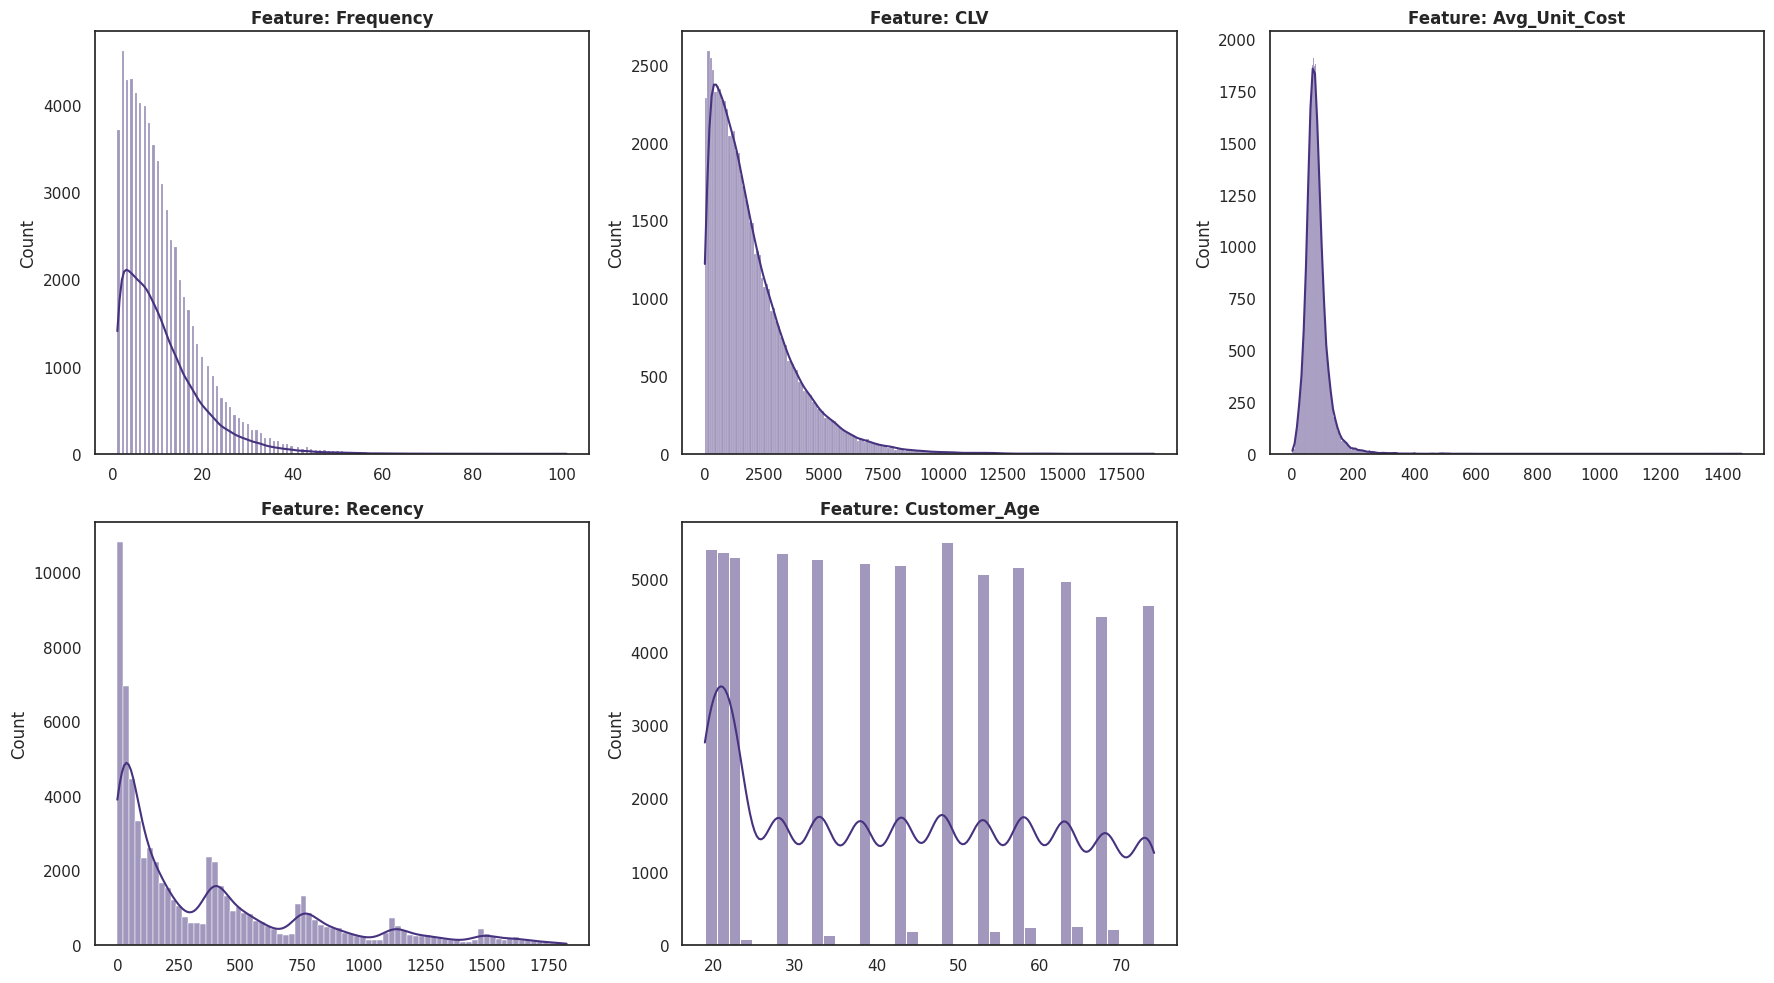

--------------------------------------------------
Feature              | Skewness Coefficient
--------------------------------------------------
Avg_Unit_Cost        |               3.8686
CLV                  |               1.7544
Frequency            |               1.7120
Recency              |               1.3713
Customer_Age         |               0.1633


In [7]:
# Configure plot aesthetics
sns.set_theme(style="white", palette="viridis")
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Visualize feature distributions
for i, col in enumerate(X.columns):
    sns.histplot(X[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Feature: {col}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('')

# Prune unused axes
if len(X.columns) < 6:
    for j in range(len(X.columns), 6):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Quantitative Skewness Assessment
print("-" * 50)
print(f"{'Feature':<20} | {'Skewness Coefficient':<20}")
print("-" * 50)
skew_report = X.skew().sort_values(ascending=False)
for feature, value in skew_report.items():
    print(f"{feature:<20} | {value:>20.4f}")

## 3.3. Outlier & Dispersion Analysis

**Objective:** Profile feature variance and quantify geometric leverage to determine the optimal scaling and transformation strategy.

**Key Findings:**

- **Univariate Leverage:** All behavioural features except Customer_Age exhibit extreme right-tail dispersion (Max values up to 16x Q3). These high-leverage points will disproportionately distort Euclidean distance metrics if left in their raw state.

- **Multivariate Consistency:** A 61.8% overlap between CLV and Frequency outliers confirms a legitimate "Power User" segment. This multivariate consistency justifies retention via robust scaling rather than truncation.

- **Preprocessing Implications:** The data dictates a dual-track preprocessing pipeline: Customer_Age requires standard $Z$-score scaling, while skewed metrics require non-linear power transformations to stabilise variance and ensure cluster convergence.

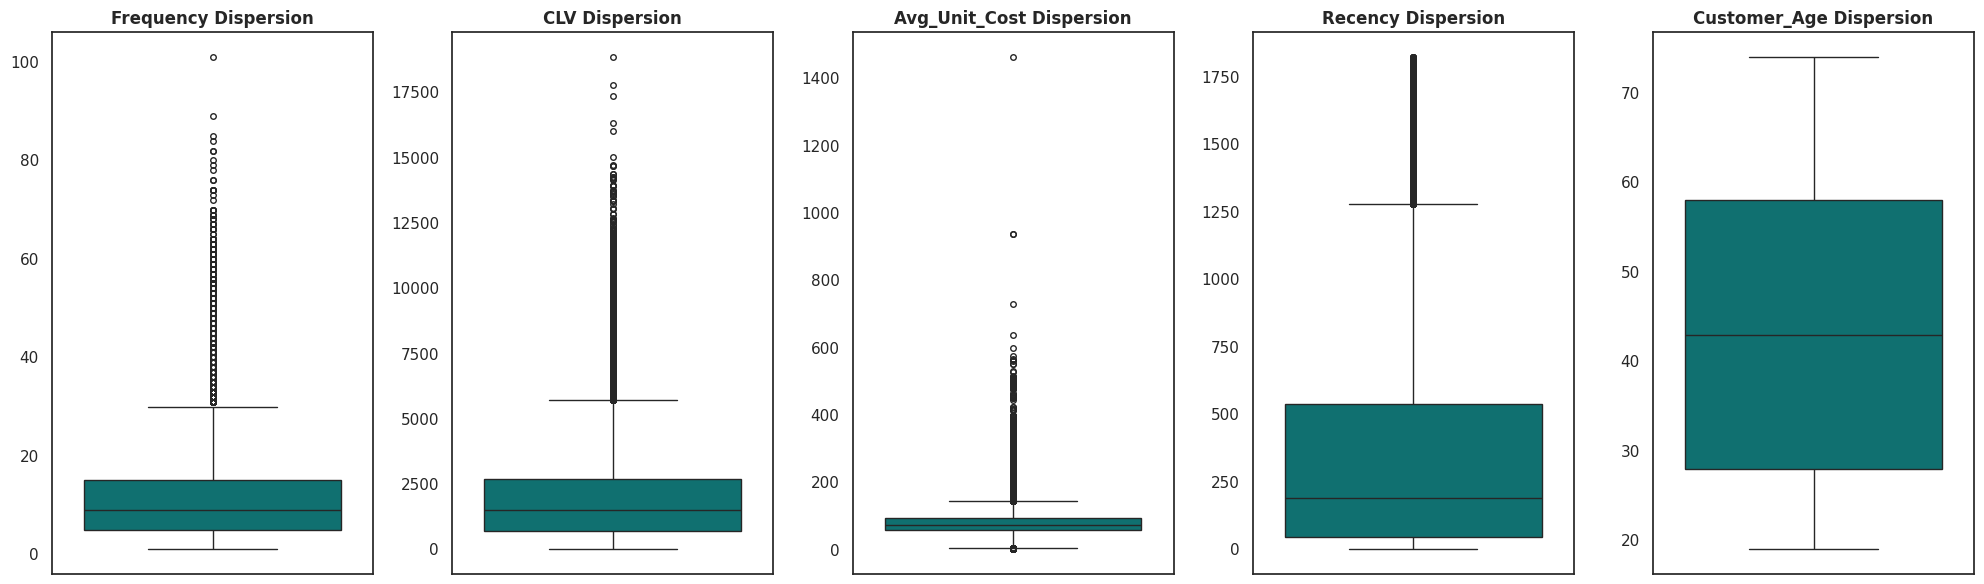


Feature         | Q3           | Max Value    | Outlier Count (%)
-----------------------------------------------------------------
Frequency       |        15.00 |       101.00 |   2,481 (3.63%)
CLV             |      2709.85 |     18860.96 |   2,590 (3.79%)
Avg_Unit_Cost   |        92.52 |      1463.50 |   2,889 (4.23%)
Recency         |       539.25 |      1824.00 |   3,361 (4.92%)
Customer_Age    |        58.00 |        74.00 |       0 (0.00%)

-----------------------------------------------------------------
CLV–Frequency Outlier Overlap: 1,600 customers (61.8% of CLV outliers)
-----------------------------------------------------------------


In [8]:
# Statistical Dispersion Profiling
fig, axes = plt.subplots(1, len(X.columns), figsize=(20, 6))
for i, col in enumerate(X.columns):
    sns.boxplot(data=X, y=col, ax=axes[i], color='teal', fliersize=4)
    axes[i].set_title(f'{col} Dispersion', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('')
plt.tight_layout()
plt.show()

# Quantitative Boundary & Overlap Analysis
outlier_indices = {}
total_records = len(X)

print(f"\n{'Feature':<15} | {'Q3':<12} | {'Max Value':<12} | {'Outlier Count (%)':<15}")
print("-" * 65)

for col in X.columns:
    q1, q3 = X[col].quantile([0.25, 0.75])
    iqr = q3 - q1
    mask = (X[col] < (q1 - 1.5 * iqr)) | (X[col] > (q3 + 1.5 * iqr))

    count = X[mask].shape[0]
    percentage = (count / total_records) * 100
    outlier_indices[col] = set(X[mask].index)

    print(f"{col:<15} | {q3:>12.2f} | {X[col].max():>12.2f} | {count:>7,} ({percentage:>4.2f}%)")

# Multivariate Behavioral Validation
loyal_high_spenders = outlier_indices['Frequency'].intersection(outlier_indices['CLV'])
overlap_pct = (len(loyal_high_spenders) / len(outlier_indices['CLV'])) * 100

print("\n" + "-" * 65)
print(f"CLV–Frequency Outlier Overlap: {len(loyal_high_spenders):,} customers ({overlap_pct:.1f}% of CLV outliers)")
print("-" * 65)


# 4\. Feature Preprocessing & Pipeline Construction

**Objective:** Implement a robust architecture to normalise the feature space, utilising the insights from the Outlier and Topology audits.

**Key Findings:**

- **Transformation Strategy:** Behavioural features require a Yeo-Johnson power transformation to resolve the high-leverage skewness identified in Section 3.

- **Pipeline Modularity:** A ColumnTransformer is utilised to isolate the Customer_Age (Standard Scaling) from the behavioural metrics (Transformation + Scaling), ensuring optimal convergence for distance-based clustering.

In [9]:
# Define feature groups based on the Distribution Audit
skewed_features = ['CLV', 'Frequency', 'Avg_Unit_Cost', 'Recency']
stable_features = ['Customer_Age']

# Construct the preprocessing pipeline
# 1. PowerTransformer (Yeo-Johnson) "squashes" the long tails of behavioral data
# 2. StandardScaler ensures all features have Mean=0 and StdDev=1
preprocessing_pipeline = ColumnTransformer(
    transformers=[
        ('behavioral', Pipeline([
            ('yeo_johnson', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ]), skewed_features),

        ('demographic', StandardScaler(), stable_features)
    ]
)

# Apply transformation
X_transformed = preprocessing_pipeline.fit_transform(X)
X_final = pd.DataFrame(X_transformed, columns=skewed_features + stable_features)

# Verification of transformation success (Skewness check)
print(f"{'Feature':<15} | {'Original Skew':<15} | {'Transformed Skew':<15}")
print("-" * 50)
for col in X.columns:
    orig_skew = X[col].skew()
    trans_skew = X_final[col].skew()
    print(f"{col:<15} | {orig_skew:>15.2f} | {trans_skew:>15.2f}")

Feature         | Original Skew   | Transformed Skew
--------------------------------------------------
Frequency       |            1.71 |           -0.02
CLV             |            1.75 |           -0.04
Avg_Unit_Cost   |            3.87 |            0.11
Recency         |            1.37 |           -0.10
Customer_Age    |            0.16 |            0.16


# 5\. Cluster Optimisation

## 5.1. Multi-Metric Cluster Evaluation

**Objective:** Identify the optimal number of segments ($k$) by balancing variance reduction (Inertia), cluster separation (Silhouette Score), and insights from hierarchical dendrogram analysis.

**Evaluation Methodologies:**

- **The Elbow Method (WCSS):** Identifying the "diminishing returns" point where additional clusters yield negligible gains in intra-cluster cohesion.

- **Silhouette Analysis:** Evaluating inter-cluster separation to ensure segments are statistically distinct and not overlapping.

- **Dendrogram Analysis:** Visualising the hierarchical merging process to identify the natural "jumps" in Euclidean distance between nested subgroups.

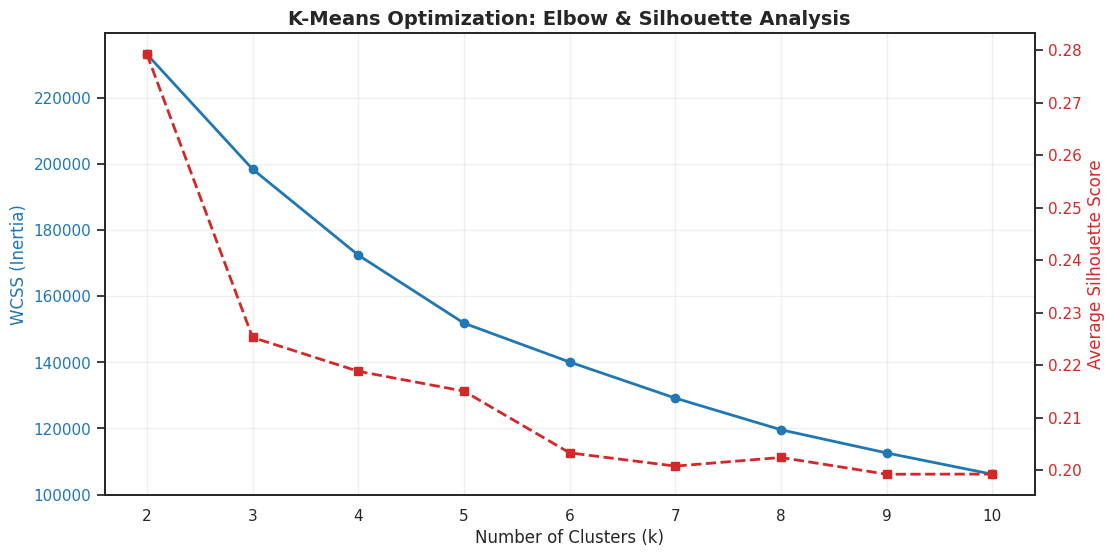

k     |            WCSS | % Reduction in WCSS  | Silhouette Score
-----------------------------------------------------------------
2     |       233317.35 |                      |          0.2792
3     |       198523.02 |      -14.9%          |          0.2253
4     |       172504.64 |      -13.1%          |          0.2188
5     |       151883.99 |      -12.0%          |          0.2150
6     |       140122.49 |       -7.7%          |          0.2033
7     |       129188.62 |       -7.8%          |          0.2008
8     |       119604.88 |       -7.4%          |          0.2024
9     |       112587.47 |       -5.9%          |          0.1992
10    |       106137.16 |       -5.7%          |          0.1993


In [10]:
wcss = [] # within-cluster sum of squares (inertia)
silhouette_avg = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=SEED)
    kmeans.fit(X_final)

    wcss.append(kmeans.inertia_)

    score = silhouette_score(X_final, kmeans.labels_)
    silhouette_avg.append(score)

# Visualising the Optimisation Metrics
fig, ax1 = plt.subplots(figsize=(12, 6))

# WCSS (Elbow) Plot
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('WCSS (Inertia)', color=color, fontsize=12)
ax1.plot(k_range, wcss, marker='o', color=color, linewidth=2, label='WCSS')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

# Silhouette Plot
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Average Silhouette Score', color=color, fontsize=12)
ax2.plot(k_range, silhouette_avg, marker='s', color=color, linewidth=2, linestyle='--', label='Silhouette')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('K-Means Optimization: Elbow & Silhouette Analysis', fontsize=14, fontweight='bold')
plt.show()

# Quantitative Summary
print(f"{'k':<5} | {'WCSS':>15} | {'% Reduction in WCSS':<20} | {'Silhouette Score':<15}")
print("-" * 65)

for i, k in enumerate(k_range):
    # Calculate reduction from previous WCSS
    if i == 0:
        reduction_str = "" # Empty for the first value
    else:
        # (Current - Previous) / Previous * 100
        reduction = ((wcss[i] - wcss[i-1]) / wcss[i-1]) * 100
        reduction_str = f"{reduction:>10.1f}%"

    print(f"{k:<5} | {wcss[i]:>15.2f} | {reduction_str:<20} | {silhouette_avg[i]:>15.4f}")


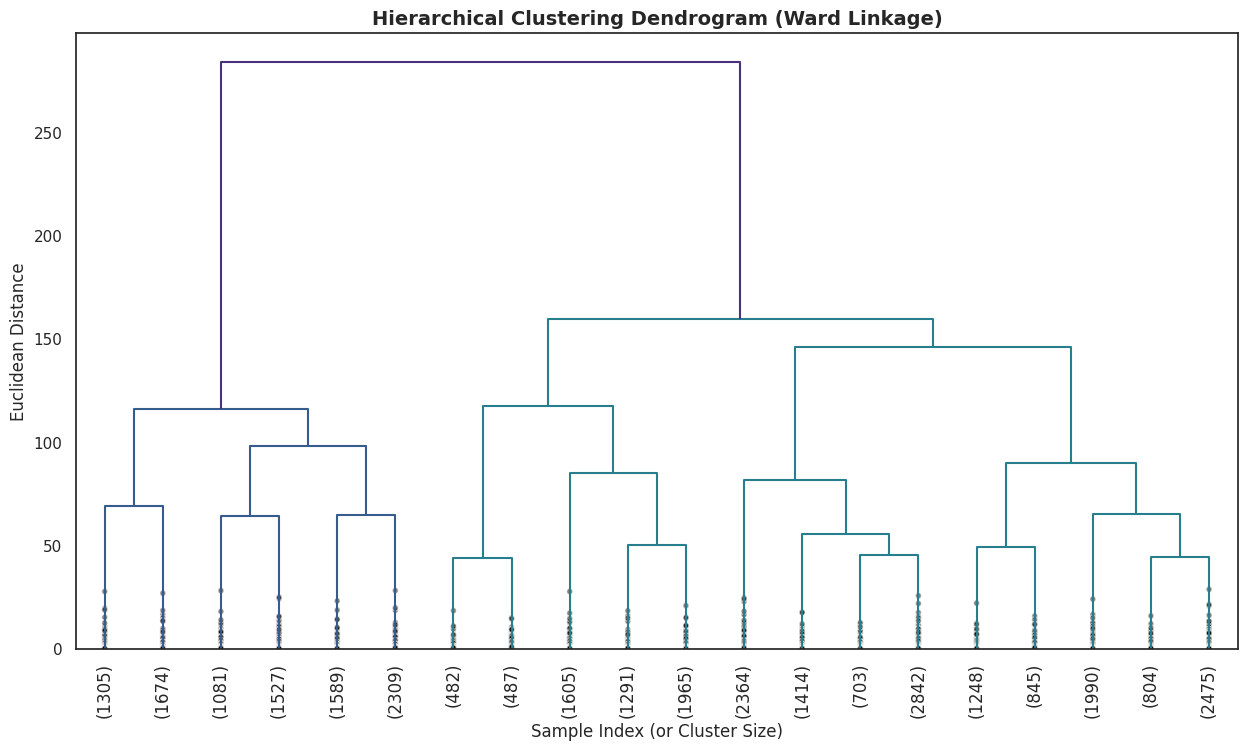

In [11]:
# Stratified sampling utilised to maintain distributional integrity while
# optimising computational performance on the 68,300 record population.
sample_size = 30000
X_sample = X_final.sample(n=sample_size, random_state=SEED)

plt.figure(figsize=(15, 8))
plt.title('Hierarchical Clustering Dendrogram (Ward Linkage)', fontsize=14, fontweight='bold')
plt.xlabel('Sample Index (or Cluster Size)', fontsize=12)
plt.ylabel('Euclidean Distance', fontsize=12)

# Linkage Matrix Construction
# Ward's method minimises within-cluster variance based on Euclidean distance.
Z = sch.linkage(X_sample, method='ward')

dendrogram = sch.dendrogram(
    Z,
    truncate_mode='lastp',
    p=20,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True
)

plt.show()

## 5.2. Selection Logic & Final Model Validation

**Decision Rationale ($k=5$):**

- **Variance Compression:** The WCSS gradient exhibits a steep descent through $k$=5 (incremental reduction of 12.0%), followed by a notable plateau at $k$=6 (7.9%). This identifies $k$=5 as the terminal point of efficient variance compression.

- **Separation Stability:** Silhouette scores maintain a stable plateau from $k$=3 through $k$=5 (0.2156) before a significant decline at $k$=6.

- **Optimal Trade-off:** While hierarchical analysis suggests partitions at $k$=4 and $k$=6, the 5-cluster solution provides the best trade-off between granularity and statistical separation.

In [12]:
# Final Model Construction (k=5)
final_k = 5
kmeans_final = KMeans(
    n_clusters=final_k,
    init='k-means++',
    n_init=20,
    max_iter=500,
    random_state=SEED
)

# Apply final labels to the original (raw) dataset for business interpretation
cluster_labels = kmeans_final.fit_predict(X_final)
df_results = X.copy()
df_results['Cluster'] = cluster_labels + 1  # Shift labels to be 1-indexed for interpretability


# 6\. Cluster Profiling & Persona Development

**Objective:** Translate mathematical clusters into actionable business personas by de-normalising centroids and evaluating the statistical "fingerprint" of each segment.

**Profiling Methodology:**

- **Re-indexing:** Cluster IDs are re-mapped to ensure a monotonic relationship with CLV, facilitating an intuitive "Value Tier" hierarchy for stakeholders.

- **Metrics:** Medians are used as the primary descriptive statistic to ensure personas represent the "typical" customer and remain robust against the distribution tails identified in the EDA.

## 6.1. Persona Characterisation

The analysis reveals five distinct archetypes based on the alignment of RFM-A dimensions:

- **Tier 5 (Champions):** The highest-value segment with **peak CLV and Frequency**. They are currently active (lowest Recency) and represent the brand’s most reliable revenue engine.

- **Tier 4 (Loyal Regulars):** A high-value group characterised by **steady, frequent transactions**. They are distinguished by being the oldest demographic (Median Age: 58), suggesting a stable, affluent segment with established purchasing habits.

- **Tier 3 (At-Risk Mid-Tiers):** Moderate value but showing concerning recency trends. They are the **youngest demographic** (Median Age: 23) and likely requiring different engagement channels.

- **Tier 2 (High-Ticket Lapsed):** A critical niche segment. They have the **highest Avg_Unit_Cost** ($117) but have not engaged in over 700 days. They represent a high-value re-activation opportunity.

- **Tier 1 (Budget Churned):** Lowest value across all metrics with low unit costs. This group likely represents **one-time transactional shoppers** who have effectively churned.

## 6.2. Central Tendency & Economic Stratification

In [13]:
# Mapping clusters to a logical Value Tier (1=Lowest CLV, 5=Highest CLV)
# This re-indexing ensures a monotonic trend for stakeholder reporting
mapping = {1: 1, 3: 2, 2: 3, 4: 4, 5: 5}
df_results['Cluster'] = df_results['Cluster'].map(mapping)

# Aggregating behavioral metrics using the Median
cluster_profiles = df_results.groupby('Cluster').agg({
    'CLV': 'median',
    'Frequency': 'median',
    'Recency': 'median',
    'Avg_Unit_Cost': 'median',
    'Customer_Age': 'median'
})

# Appending volume metrics
cluster_profiles['Volume'] = df_results['Cluster'].value_counts()
cluster_profiles['Population_%'] = (cluster_profiles['Volume'] / len(df_results)) * 100

# Display clean profiling table
print("\nFinal Segment Profiles: Median Behavioral Metrics")
print("-" * 90)

cluster_profiles = cluster_profiles.sort_index(ascending=False)
display(cluster_profiles.style.format({
    'CLV': '${:,.2f}',
    'Frequency': '{:.1f} tx',
    'Recency': '{:.0f} days',
    'Avg_Unit_Cost': '${:,.2f}',
    'Customer_Age': '{:.1f} yrs',
    'Volume': '{:,.0f}',
    'Population_%': '{:.1f}%'
}).background_gradient(
    cmap='Blues',
    subset=['CLV', 'Frequency']
).background_gradient(
    cmap='Blues_r',
    subset=['Recency']
))


Final Segment Profiles: Median Behavioral Metrics
------------------------------------------------------------------------------------------


,CLV,Frequency,Recency,Avg_Unit_Cost,Customer_Age,Volume,Population_%
Cluster,,,,,,,
5,"$3,759.50",20.0 tx,33 days,$79.65,33.0 yrs,"16,501",24.2%
4,"$1,630.30",10.0 tx,112 days,$71.42,58.0 yrs,"16,053",23.5%
3,"$1,347.10",9.0 tx,279 days,$70.88,23.0 yrs,"16,613",24.3%
2,$818.60,3.0 tx,722 days,$117.15,48.0 yrs,"8,586",12.6%
1,$243.10,3.0 tx,716 days,$42.50,53.0 yrs,"10,547",15.4%


## 6.3. Structural Validation via Feature Distribution

**Objective:** Confirm intra-cluster cohesion and inter-cluster separation using notched boxplots to identify statistical significance in segment boundaries.

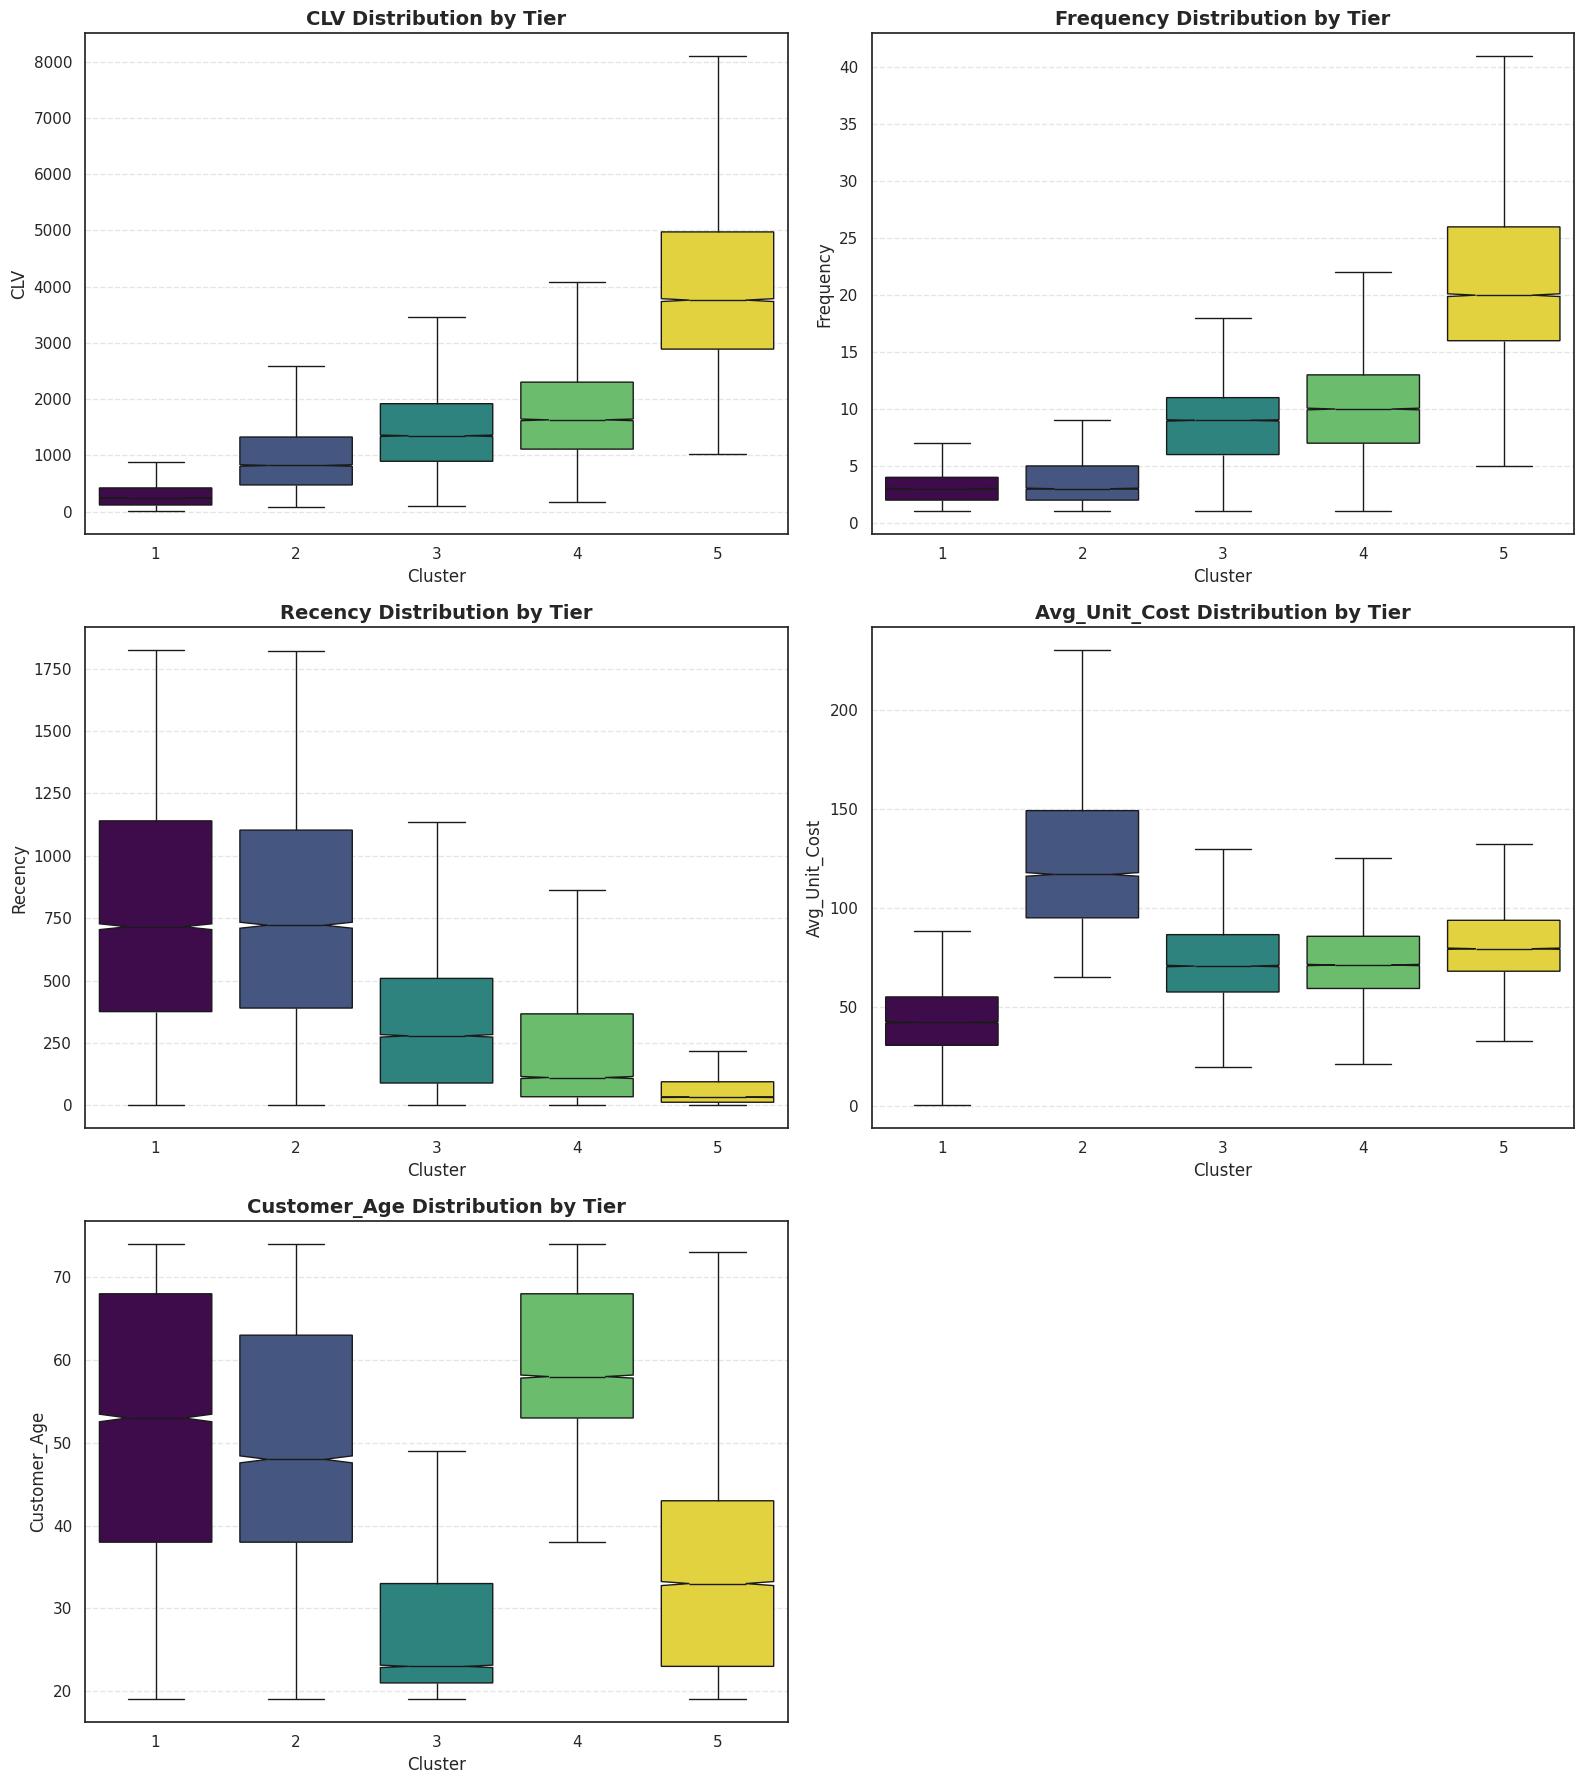

In [14]:
# Multi-feature distribution audit
features_to_plot = ['CLV', 'Frequency', 'Recency', 'Avg_Unit_Cost', 'Customer_Age']
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.boxplot(
        data=df_results,
        x='Cluster',
        y=col,
        hue='Cluster',
        ax=axes[i],
        palette='viridis',
        showfliers=False,
        legend=False,
        notch=True
    )
    axes[i].set_title(f'{col} Distribution by Tier', fontsize=14, fontweight='bold')
    axes[i].grid(axis='y', linestyle='--', alpha=0.5)

# Remove the empty 6th subplot
if len(features_to_plot) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

## 6.4. High-Dimensional Projection

**Objective:** To visually audit cluster distinctness and density by projecting the 5D feature space into 2D using linear (PCA) and non-linear (t-SNE) dimensionality reduction.

**Key Findings:**

- **PCA** shows moderate separation but substantial overlap between Tiers 3 and 4, indicating that these segments share similar global variance and are differentiated by subtle non-linear features.

- **t-SNE** reveals fragmented shapes and significant cluster blending rather than isolated "islands". This suggests a dense, continuous customer landscape where behavioral transitions between tiers are gradual rather than discrete.

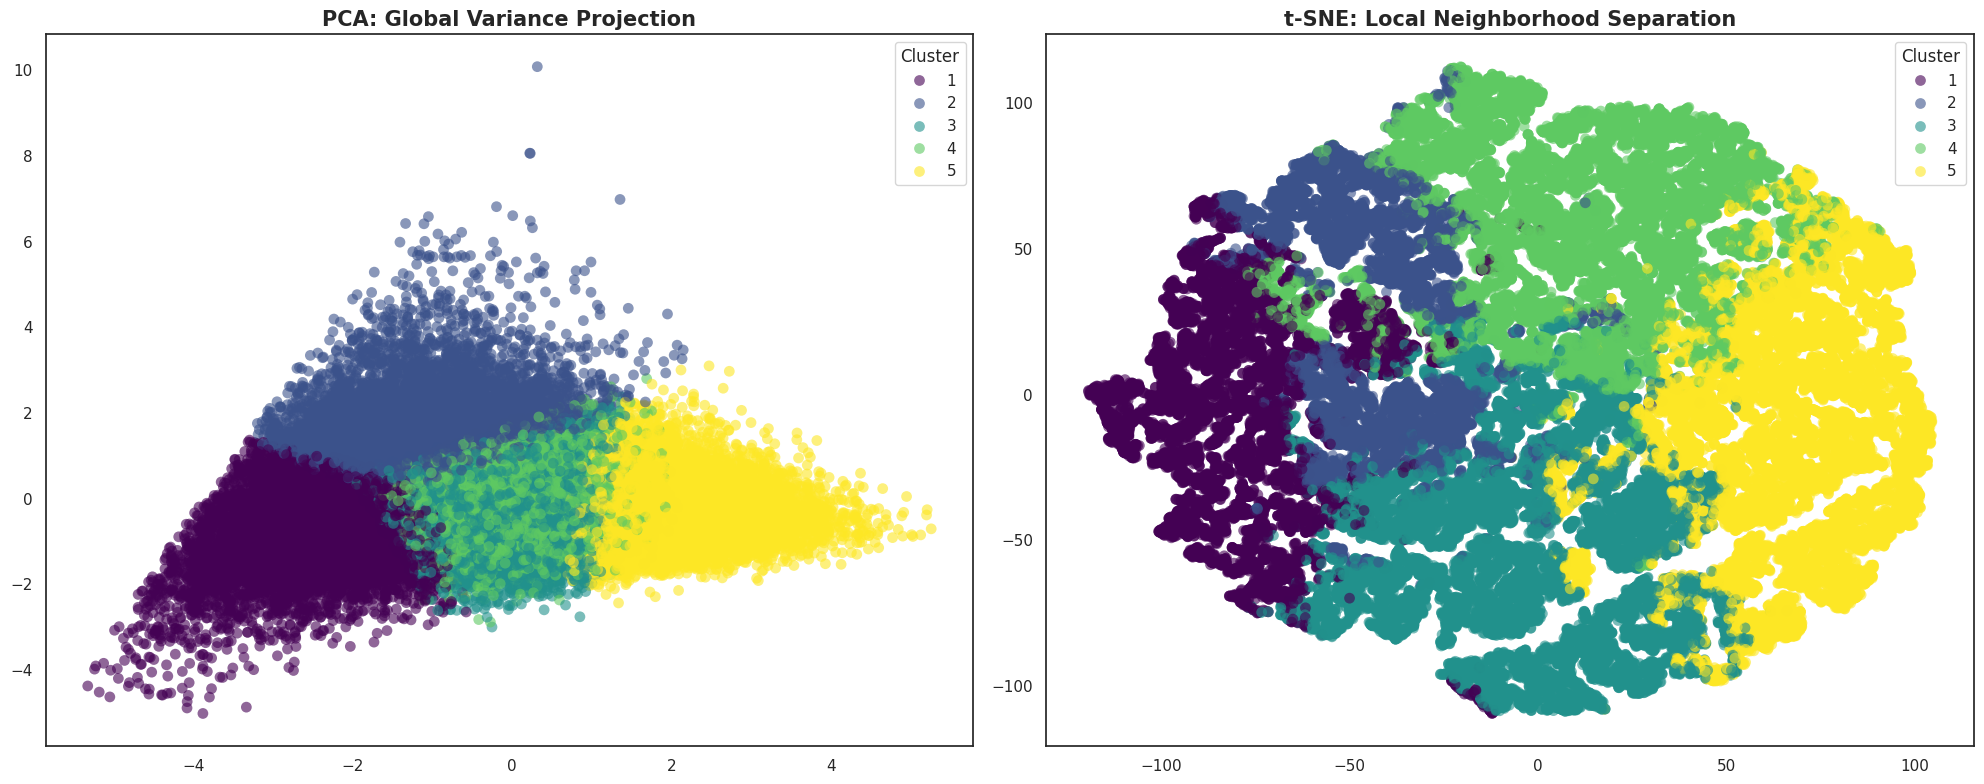

In [15]:
# PCA Projection (Linear)
pca = PCA(n_components=2, random_state=SEED)
X_pca = pca.fit_transform(X_final)

# t-SNE Projection (Non-linear)
tsne = TSNE(n_components=2, perplexity=50, random_state=SEED, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X_final)

# 4. Visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# PCA Plot
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_results['Cluster'],
                palette='viridis', ax=ax1, s=60, alpha=0.6, edgecolor='none')
ax1.set_title('PCA: Global Variance Projection', fontsize=15, fontweight='bold')

# t-SNE Plot
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=df_results['Cluster'],
                palette='viridis', ax=ax2, s=60, alpha=0.6, edgecolor='none')
ax2.set_title('t-SNE: Local Neighborhood Separation', fontsize=15, fontweight='bold')

plt.tight_layout()
plt.show()

# 7\. Business Recommendations

## 7.1. High-Value Retention (Tiers 4 & 5)

**Objective:** Protect the revenue core

**Rationale:**
These segments account for the **highest CLV and purchase frequency** with strong recent engagement. Churn in Tier 5 has an outsized negative impact on total revenue.

**Data-Driven Actions:**
- Prioritise retention monitoring (early churn signals, recency drift)

- Allocate the lowest churn-risk tolerance and highest service reliability to these tiers

- Use these segments as the **baseline cohort** for retention KPI benchmarking

## 7.2. Value Uplift & Reactivation (Tiers 2 & 3)

**Objective:** Convert latent value into sustained growth

**Rationale:**
- **Tier 3** represents long-term upside with moderate value but increasing recency risk

- **Tier 2** exhibits high spend per order but extended inactivity, indicating recoverable value

**Data-Driven Actions:**
- Target for **controlled reactivation experiments** (uplift measured vs. holdout)

- Track movement probability into higher-value tiers as the primary success metric

- Prioritise feature-level drivers (recency, frequency) rather than broad engagement

## 7.3. Cost-Controlled Engagement (Tier 1)

**Objective:** Minimise negative ROI exposure

**Rationale:**
This segment shows consistently low value and high churn likelihood. Aggressive re-engagement would likely exceed recoverable value.

**Data-Driven Actions:**
- Apply strict CAC ceilings or passive engagement only

- Exclude from performance-critical campaigns

- Monitor for natural migration signals before investment

# 8\. Project Conclusion & Technical Reflection

This project applied unsupervised learning to a **68k-customer, 950k-transaction dataset**, producing **five actionable customer tiers**. Key outcomes:

- **Customer-Centric Features:** RFM-A metrics captured engagement, value, and demographics.

- **Robust Preprocessing:** Skewed and high-leverage features were transformed and standardised for stable clustering.

- **Optimal Segmentation:** Multi-metric evaluation (WCSS, silhouette, dendrogram) identified **k=5** clusters.

- **Actionable Insights:** Tiered personas guide retention, growth, and cost-controlled engagement strategies.

## Reflection

The modular pipeline ensures reproducibility, while PCA/t-SNE confirm cluster separation. Future improvements include temporal validation, segment drift monitoring, and predictive modeling for retention and upsell.